## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

from keras.datasets import cifar10
from keras.utils import np_utils

import warnings
warnings.filterwarnings('ignore')

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = np_utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [8]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import optimizers

optimizer_set = [optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 optimizers.Adam(lr=LEARNING_RATE),
                 optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.3, 0.5, 0.8]
redice_lr_patient = [3, 5, 8]

In [9]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=reduce_patient, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.30, reduce_patient: 3
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 hidden_layer2 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 hi

49/49 [==============================] - 4s 77ms/step - loss: 1.7160 - accuracy: 0.3968 - val_loss: 1.7890 - val_accuracy: 0.3686 - lr: 3.0000e-04
Epoch 6/25
49/49 [==============================] - 4s 83ms/step - loss: 1.6710 - accuracy: 0.4117 - val_loss: 1.7284 - val_accuracy: 0.3893 - lr: 3.0000e-04
Epoch 7/25
49/49 [==============================] - 4s 89ms/step - loss: 1.6341 - accuracy: 0.4240 - val_loss: 1.6925 - val_accuracy: 0.4060 - lr: 3.0000e-04
Epoch 8/25
49/49 [==============================] - 4s 87ms/step - loss: 1.6047 - accuracy: 0.4336 - val_loss: 1.6726 - val_accuracy: 0.4130 - lr: 3.0000e-04
Epoch 9/25
49/49 [==============================] - 4s 83ms/step - loss: 1.5770 - accuracy: 0.4445 - val_loss: 1.6506 - val_accuracy: 0.4178 - lr: 3.0000e-04
Epoch 10/25
49/49 [==============================] - 4s 91ms/step - loss: 1.5524 - accuracy: 0.4520 - val_loss: 1.6392 - val_accuracy: 0.4222 - lr: 3.0000e-04
Epoch 11/25
49/49 [==============================] - 5s 93ms/s

Epoch 21/25
49/49 [==============================] - 4s 81ms/step - loss: 1.3709 - accuracy: 0.5226 - val_loss: 1.5378 - val_accuracy: 0.4625 - lr: 3.0000e-04
Epoch 22/25
49/49 [==============================] - 4s 90ms/step - loss: 1.3593 - accuracy: 0.5271 - val_loss: 1.5307 - val_accuracy: 0.4650 - lr: 3.0000e-04
Epoch 23/25
49/49 [==============================] - 4s 92ms/step - loss: 1.3484 - accuracy: 0.5318 - val_loss: 1.5263 - val_accuracy: 0.4640 - lr: 3.0000e-04
Epoch 24/25
49/49 [==============================] - 4s 92ms/step - loss: 1.3385 - accuracy: 0.5352 - val_loss: 1.5201 - val_accuracy: 0.4636 - lr: 3.0000e-04
Epoch 25/25
49/49 [==============================] - 5s 94ms/step - loss: 1.3286 - accuracy: 0.5393 - val_loss: 1.5143 - val_accuracy: 0.4687 - lr: 3.0000e-04
Numbers of exp: 3, reduce_factor: 0.50, reduce_patient: 3
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #  

Epoch 1/25
49/49 [==============================] - 7s 85ms/step - loss: 2.5364 - accuracy: 0.1942 - val_loss: 2.1984 - val_accuracy: 0.2210 - lr: 3.0000e-04
Epoch 2/25
49/49 [==============================] - 4s 80ms/step - loss: 2.0225 - accuracy: 0.3083 - val_loss: 2.0825 - val_accuracy: 0.2664 - lr: 3.0000e-04
Epoch 3/25
49/49 [==============================] - 5s 93ms/step - loss: 1.8675 - accuracy: 0.3517 - val_loss: 1.9671 - val_accuracy: 0.3233 - lr: 3.0000e-04
Epoch 4/25
49/49 [==============================] - 5s 94ms/step - loss: 1.7832 - accuracy: 0.3773 - val_loss: 1.8600 - val_accuracy: 0.3480 - lr: 3.0000e-04
Epoch 5/25
49/49 [==============================] - 4s 86ms/step - loss: 1.7222 - accuracy: 0.3959 - val_loss: 1.7828 - val_accuracy: 0.3818 - lr: 3.0000e-04
Epoch 6/25
49/49 [==============================] - 4s 79ms/step - loss: 1.6763 - accuracy: 0.4118 - val_loss: 1.7315 - val_accuracy: 0.3959 - lr: 3.0000e-04
Epoch 7/25
49/49 [==============================] - 

Epoch 17/25
49/49 [==============================] - 4s 79ms/step - loss: 1.4348 - accuracy: 0.4999 - val_loss: 1.5867 - val_accuracy: 0.4471 - lr: 3.0000e-04
Epoch 18/25
49/49 [==============================] - 4s 79ms/step - loss: 1.4215 - accuracy: 0.5038 - val_loss: 1.5763 - val_accuracy: 0.4535 - lr: 3.0000e-04
Epoch 19/25
49/49 [==============================] - 4s 76ms/step - loss: 1.4095 - accuracy: 0.5085 - val_loss: 1.5710 - val_accuracy: 0.4504 - lr: 3.0000e-04
Epoch 20/25
49/49 [==============================] - 3s 68ms/step - loss: 1.3963 - accuracy: 0.5124 - val_loss: 1.5651 - val_accuracy: 0.4555 - lr: 3.0000e-04
Epoch 21/25
49/49 [==============================] - 4s 90ms/step - loss: 1.3851 - accuracy: 0.5179 - val_loss: 1.5617 - val_accuracy: 0.4527 - lr: 3.0000e-04
Epoch 22/25
49/49 [==============================] - 4s 83ms/step - loss: 1.3720 - accuracy: 0.5238 - val_loss: 1.5564 - val_accuracy: 0.4561 - lr: 3.0000e-04
Epoch 23/25
49/49 [===========================

 hidden_layer3 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_23 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 923,914
Trainable params: 922,378
Non-trainable params: 1,536
_________________________________________________________________
Epoch 1/25
49/49 [==============================] - 9s 114ms/step - loss: 2.4859 - accuracy: 0.2168 - val_loss: 2.2043 - val_accuracy: 0.1425 - lr: 3.0000e-04
Epoch 2/25
49/49 [==============================] - 4s 82ms/step - loss: 1.9864 - accuracy: 0.3259 - val_loss: 2.0663 - val_accuracy: 0.2389 - lr: 3.0000e-04
Epoch 3/25
49/49 [==============================] - 4s 84ms/step - loss: 1.8401

49/49 [==============================] - 4s 85ms/step - loss: 1.5109 - accuracy: 0.4731 - val_loss: 1.6098 - val_accuracy: 0.4378 - lr: 3.0000e-04
Epoch 13/25
49/49 [==============================] - 4s 85ms/step - loss: 1.4923 - accuracy: 0.4794 - val_loss: 1.6042 - val_accuracy: 0.4372 - lr: 3.0000e-04
Epoch 14/25
49/49 [==============================] - 4s 83ms/step - loss: 1.4758 - accuracy: 0.4835 - val_loss: 1.5965 - val_accuracy: 0.4413 - lr: 3.0000e-04
Epoch 15/25
49/49 [==============================] - 4s 82ms/step - loss: 1.4598 - accuracy: 0.4901 - val_loss: 1.5837 - val_accuracy: 0.4447 - lr: 3.0000e-04
Epoch 16/25
49/49 [==============================] - 4s 89ms/step - loss: 1.4450 - accuracy: 0.4944 - val_loss: 1.5782 - val_accuracy: 0.4475 - lr: 3.0000e-04
Epoch 17/25
49/49 [==============================] - 4s 85ms/step - loss: 1.4304 - accuracy: 0.5015 - val_loss: 1.5715 - val_accuracy: 0.4495 - lr: 3.0000e-04
Epoch 18/25
49/49 [==============================] - 4s 86

49/49 [==============================] - 2s 47ms/step - loss: 0.5411 - accuracy: 0.8383 - val_loss: 1.4041 - val_accuracy: 0.5404 - lr: 2.7000e-05
Epoch 25/25
49/49 [==============================] - 2s 46ms/step - loss: 0.5338 - accuracy: 0.8429 - val_loss: 1.4011 - val_accuracy: 0.5425 - lr: 8.1000e-06
Numbers of exp: 10, reduce_factor: 0.30, reduce_patient: 5
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization_30 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_layer2 (Dense) 

Epoch 4/25
49/49 [==============================] - 2s 44ms/step - loss: 1.7391 - accuracy: 0.3958 - val_loss: 1.8431 - val_accuracy: 0.3507 - lr: 8.1000e-06
Epoch 5/25
49/49 [==============================] - 2s 45ms/step - loss: 1.6957 - accuracy: 0.4096 - val_loss: 1.7745 - val_accuracy: 0.3734 - lr: 8.1000e-06
Epoch 6/25
49/49 [==============================] - 2s 46ms/step - loss: 1.6630 - accuracy: 0.4200 - val_loss: 1.7222 - val_accuracy: 0.3892 - lr: 8.1000e-06
Epoch 7/25
49/49 [==============================] - 2s 46ms/step - loss: 1.6359 - accuracy: 0.4302 - val_loss: 1.6898 - val_accuracy: 0.4008 - lr: 8.1000e-06
Epoch 8/25
49/49 [==============================] - 2s 46ms/step - loss: 1.6117 - accuracy: 0.4386 - val_loss: 1.6754 - val_accuracy: 0.4095 - lr: 8.1000e-06
Epoch 9/25
49/49 [==============================] - 2s 46ms/step - loss: 1.5911 - accuracy: 0.4451 - val_loss: 1.6647 - val_accuracy: 0.4179 - lr: 8.1000e-06
Epoch 10/25
49/49 [==============================] -

Epoch 20/25
49/49 [==============================] - 2s 48ms/step - loss: 1.4510 - accuracy: 0.4922 - val_loss: 1.5906 - val_accuracy: 0.4415 - lr: 8.1000e-06
Epoch 21/25
49/49 [==============================] - 2s 47ms/step - loss: 1.4425 - accuracy: 0.4973 - val_loss: 1.5873 - val_accuracy: 0.4458 - lr: 8.1000e-06
Epoch 22/25
49/49 [==============================] - 2s 48ms/step - loss: 1.4351 - accuracy: 0.4992 - val_loss: 1.5827 - val_accuracy: 0.4441 - lr: 8.1000e-06
Epoch 23/25
49/49 [==============================] - 2s 48ms/step - loss: 1.4259 - accuracy: 0.5030 - val_loss: 1.5785 - val_accuracy: 0.4459 - lr: 8.1000e-06
Epoch 24/25
49/49 [==============================] - 3s 52ms/step - loss: 1.4184 - accuracy: 0.5046 - val_loss: 1.5757 - val_accuracy: 0.4498 - lr: 8.1000e-06
Epoch 25/25
49/49 [==============================] - 2s 49ms/step - loss: 1.4099 - accuracy: 0.5070 - val_loss: 1.5719 - val_accuracy: 0.4496 - lr: 8.1000e-06
Numbers of exp: 13, reduce_factor: 0.50, reduc

Total params: 923,914
Trainable params: 922,378
Non-trainable params: 1,536
_________________________________________________________________
Epoch 1/25
49/49 [==============================] - 4s 57ms/step - loss: 2.3072 - accuracy: 0.2548 - val_loss: 2.1794 - val_accuracy: 0.1969 - lr: 8.1000e-06
Epoch 2/25
49/49 [==============================] - 2s 48ms/step - loss: 1.9195 - accuracy: 0.3444 - val_loss: 2.0751 - val_accuracy: 0.2682 - lr: 8.1000e-06
Epoch 3/25
49/49 [==============================] - 2s 48ms/step - loss: 1.8088 - accuracy: 0.3734 - val_loss: 1.9628 - val_accuracy: 0.2983 - lr: 8.1000e-06
Epoch 4/25
49/49 [==============================] - 2s 48ms/step - loss: 1.7416 - accuracy: 0.3969 - val_loss: 1.8593 - val_accuracy: 0.3374 - lr: 8.1000e-06
Epoch 5/25
49/49 [==============================] - 2s 49ms/step - loss: 1.6965 - accuracy: 0.4116 - val_loss: 1.7816 - val_accuracy: 0.3654 - lr: 8.1000e-06
Epoch 6/25
49/49 [==============================] - 2s 49ms/step - l

Epoch 16/25
49/49 [==============================] - 3s 58ms/step - loss: 1.4881 - accuracy: 0.4838 - val_loss: 1.6069 - val_accuracy: 0.4376 - lr: 8.1000e-06
Epoch 17/25
49/49 [==============================] - 3s 59ms/step - loss: 1.4765 - accuracy: 0.4877 - val_loss: 1.6044 - val_accuracy: 0.4379 - lr: 8.1000e-06
Epoch 18/25
49/49 [==============================] - 3s 64ms/step - loss: 1.4664 - accuracy: 0.4926 - val_loss: 1.5961 - val_accuracy: 0.4411 - lr: 8.1000e-06
Epoch 19/25
49/49 [==============================] - 3s 60ms/step - loss: 1.4578 - accuracy: 0.4942 - val_loss: 1.5934 - val_accuracy: 0.4437 - lr: 8.1000e-06
Epoch 20/25
49/49 [==============================] - 3s 60ms/step - loss: 1.4488 - accuracy: 0.4968 - val_loss: 1.5891 - val_accuracy: 0.4445 - lr: 8.1000e-06
Epoch 21/25
49/49 [==============================] - 3s 60ms/step - loss: 1.4399 - accuracy: 0.5021 - val_loss: 1.5836 - val_accuracy: 0.4465 - lr: 8.1000e-06
Epoch 22/25
49/49 [===========================

 chNormalization)                                                
                                                                 
 hidden_layer3 (Dense)       (None, 256)               65792     
                                                                 
 batch_normalization_53 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 output (Dense)              (None, 10)                2570      
                                                                 
Total params: 923,914
Trainable params: 922,378
Non-trainable params: 1,536
_________________________________________________________________
Epoch 1/25
49/49 [==============================] - 3s 52ms/step - loss: 2.3247 - accuracy: 0.2370 - val_loss: 2.2086 - val_accuracy: 0.1721 - lr: 8.1000e-06
Epoch 2/25
49/49 [==============================] - 2s 50ms/step - loss: 1.8915 - accuracy: 0.3460 - val_l

Epoch 11/25
49/49 [==============================] - 3s 54ms/step - loss: 0.8936 - accuracy: 0.6935 - val_loss: 1.4181 - val_accuracy: 0.5016 - lr: 3.0000e-04
Epoch 12/25
49/49 [==============================] - 3s 52ms/step - loss: 0.8646 - accuracy: 0.7058 - val_loss: 1.4353 - val_accuracy: 0.4980 - lr: 3.0000e-04
Epoch 13/25
49/49 [==============================] - 2s 49ms/step - loss: 0.8362 - accuracy: 0.7150 - val_loss: 1.3672 - val_accuracy: 0.5294 - lr: 3.0000e-04
Epoch 14/25
49/49 [==============================] - 3s 51ms/step - loss: 0.8103 - accuracy: 0.7261 - val_loss: 1.3704 - val_accuracy: 0.5246 - lr: 3.0000e-04
Epoch 15/25
49/49 [==============================] - 3s 51ms/step - loss: 0.7851 - accuracy: 0.7341 - val_loss: 1.4105 - val_accuracy: 0.5176 - lr: 3.0000e-04
Epoch 16/25
48/49 [============================>.] - ETA: 0s - loss: 0.7635 - accuracy: 0.7438
Epoch 16: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
49/49 [==========================

Epoch 24/25
49/49 [==============================] - 3s 54ms/step - loss: 1.5462 - accuracy: 0.4604 - val_loss: 1.6604 - val_accuracy: 0.4289 - lr: 8.1000e-06
Epoch 25/25
49/49 [==============================] - 3s 53ms/step - loss: 1.5366 - accuracy: 0.4632 - val_loss: 1.6508 - val_accuracy: 0.4309 - lr: 8.1000e-06
Numbers of exp: 20, reduce_factor: 0.30, reduce_patient: 8
Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 3072)]            0         
                                                                 
 hidden_layer1 (Dense)       (None, 256)               786688    
                                                                 
 batch_normalization_60 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 hidden_lay

Epoch 4/25
49/49 [==============================] - 3s 53ms/step - loss: 2.0796 - accuracy: 0.2987 - val_loss: 2.0208 - val_accuracy: 0.2836 - lr: 8.1000e-06
Epoch 5/25
49/49 [==============================] - 3s 53ms/step - loss: 2.0041 - accuracy: 0.3188 - val_loss: 1.9568 - val_accuracy: 0.3055 - lr: 8.1000e-06
Epoch 6/25
49/49 [==============================] - 3s 52ms/step - loss: 1.9438 - accuracy: 0.3343 - val_loss: 1.9078 - val_accuracy: 0.3256 - lr: 8.1000e-06
Epoch 7/25
49/49 [==============================] - 3s 52ms/step - loss: 1.8965 - accuracy: 0.3486 - val_loss: 1.8737 - val_accuracy: 0.3402 - lr: 8.1000e-06
Epoch 8/25
49/49 [==============================] - 3s 53ms/step - loss: 1.8569 - accuracy: 0.3591 - val_loss: 1.8549 - val_accuracy: 0.3497 - lr: 8.1000e-06
Epoch 9/25
49/49 [==============================] - 3s 53ms/step - loss: 1.8225 - accuracy: 0.3694 - val_loss: 1.8320 - val_accuracy: 0.3604 - lr: 8.1000e-06
Epoch 10/25
49/49 [==============================] -

Epoch 20/25
49/49 [==============================] - 2s 51ms/step - loss: 1.6033 - accuracy: 0.4431 - val_loss: 1.7110 - val_accuracy: 0.4066 - lr: 8.1000e-06
Epoch 21/25
49/49 [==============================] - 2s 49ms/step - loss: 1.5903 - accuracy: 0.4464 - val_loss: 1.7003 - val_accuracy: 0.4099 - lr: 8.1000e-06
Epoch 22/25
49/49 [==============================] - 2s 50ms/step - loss: 1.5793 - accuracy: 0.4508 - val_loss: 1.6908 - val_accuracy: 0.4133 - lr: 8.1000e-06
Epoch 23/25
49/49 [==============================] - 3s 51ms/step - loss: 1.5676 - accuracy: 0.4541 - val_loss: 1.6837 - val_accuracy: 0.4166 - lr: 8.1000e-06
Epoch 24/25
49/49 [==============================] - 3s 54ms/step - loss: 1.5565 - accuracy: 0.4583 - val_loss: 1.6746 - val_accuracy: 0.4201 - lr: 8.1000e-06
Epoch 25/25
49/49 [==============================] - 3s 52ms/step - loss: 1.5460 - accuracy: 0.4633 - val_loss: 1.6699 - val_accuracy: 0.4207 - lr: 8.1000e-06
Numbers of exp: 23, reduce_factor: 0.50, reduc

Total params: 923,914
Trainable params: 922,378
Non-trainable params: 1,536
_________________________________________________________________
Epoch 1/25
49/49 [==============================] - 4s 56ms/step - loss: 2.6250 - accuracy: 0.1685 - val_loss: 2.2645 - val_accuracy: 0.1465 - lr: 8.1000e-06
Epoch 2/25
49/49 [==============================] - 3s 52ms/step - loss: 2.3267 - accuracy: 0.2306 - val_loss: 2.2026 - val_accuracy: 0.1874 - lr: 8.1000e-06
Epoch 3/25
49/49 [==============================] - 3s 52ms/step - loss: 2.1753 - accuracy: 0.2690 - val_loss: 2.1223 - val_accuracy: 0.2295 - lr: 8.1000e-06
Epoch 4/25
49/49 [==============================] - 3s 53ms/step - loss: 2.0722 - accuracy: 0.2959 - val_loss: 2.0409 - val_accuracy: 0.2622 - lr: 8.1000e-06
Epoch 5/25
49/49 [==============================] - 3s 53ms/step - loss: 2.0005 - accuracy: 0.3162 - val_loss: 1.9691 - val_accuracy: 0.2871 - lr: 8.1000e-06
Epoch 6/25
49/49 [==============================] - 3s 59ms/step - l

Epoch 16/25
49/49 [==============================] - 3s 57ms/step - loss: 1.6727 - accuracy: 0.4186 - val_loss: 1.7467 - val_accuracy: 0.3977 - lr: 8.1000e-06
Epoch 17/25
49/49 [==============================] - 3s 55ms/step - loss: 1.6568 - accuracy: 0.4228 - val_loss: 1.7413 - val_accuracy: 0.3977 - lr: 8.1000e-06
Epoch 18/25
49/49 [==============================] - 3s 61ms/step - loss: 1.6404 - accuracy: 0.4297 - val_loss: 1.7322 - val_accuracy: 0.4010 - lr: 8.1000e-06
Epoch 19/25
49/49 [==============================] - 3s 54ms/step - loss: 1.6269 - accuracy: 0.4340 - val_loss: 1.7227 - val_accuracy: 0.4011 - lr: 8.1000e-06
Epoch 20/25
49/49 [==============================] - 3s 55ms/step - loss: 1.6130 - accuracy: 0.4391 - val_loss: 1.7143 - val_accuracy: 0.4035 - lr: 8.1000e-06
Epoch 21/25
49/49 [==============================] - 3s 51ms/step - loss: 1.6011 - accuracy: 0.4438 - val_loss: 1.7035 - val_accuracy: 0.4104 - lr: 8.1000e-06
Epoch 22/25
49/49 [===========================

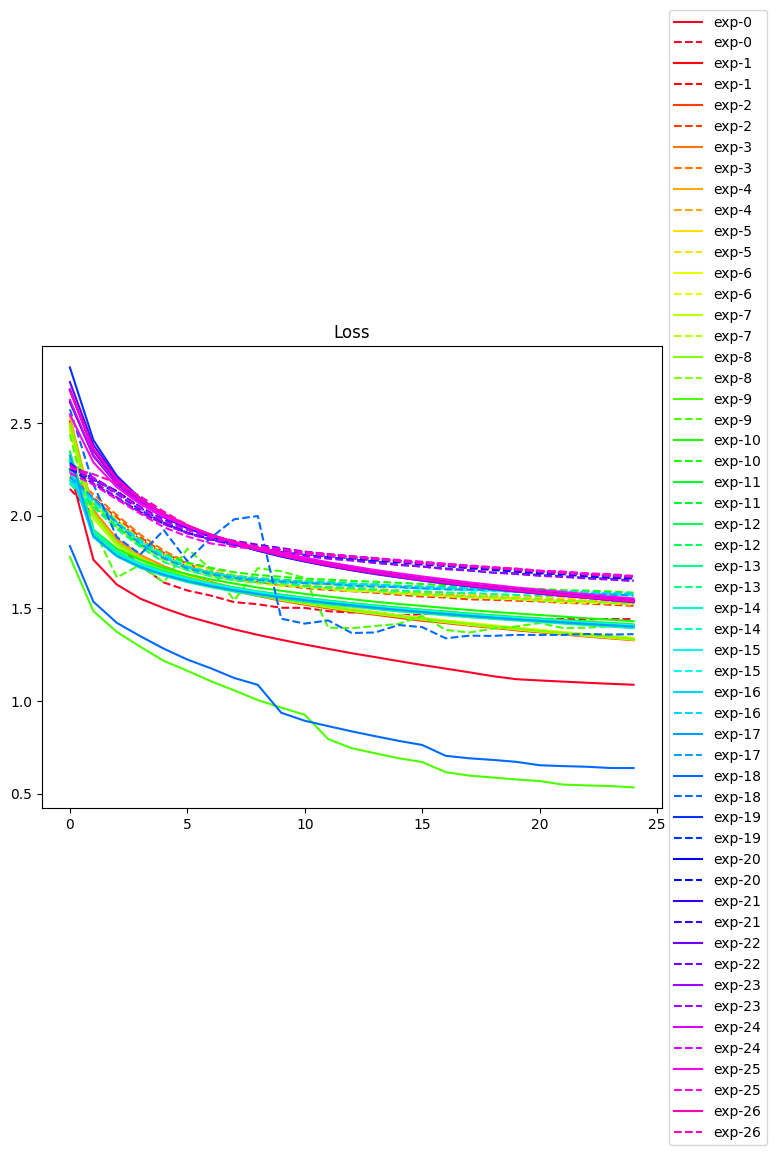

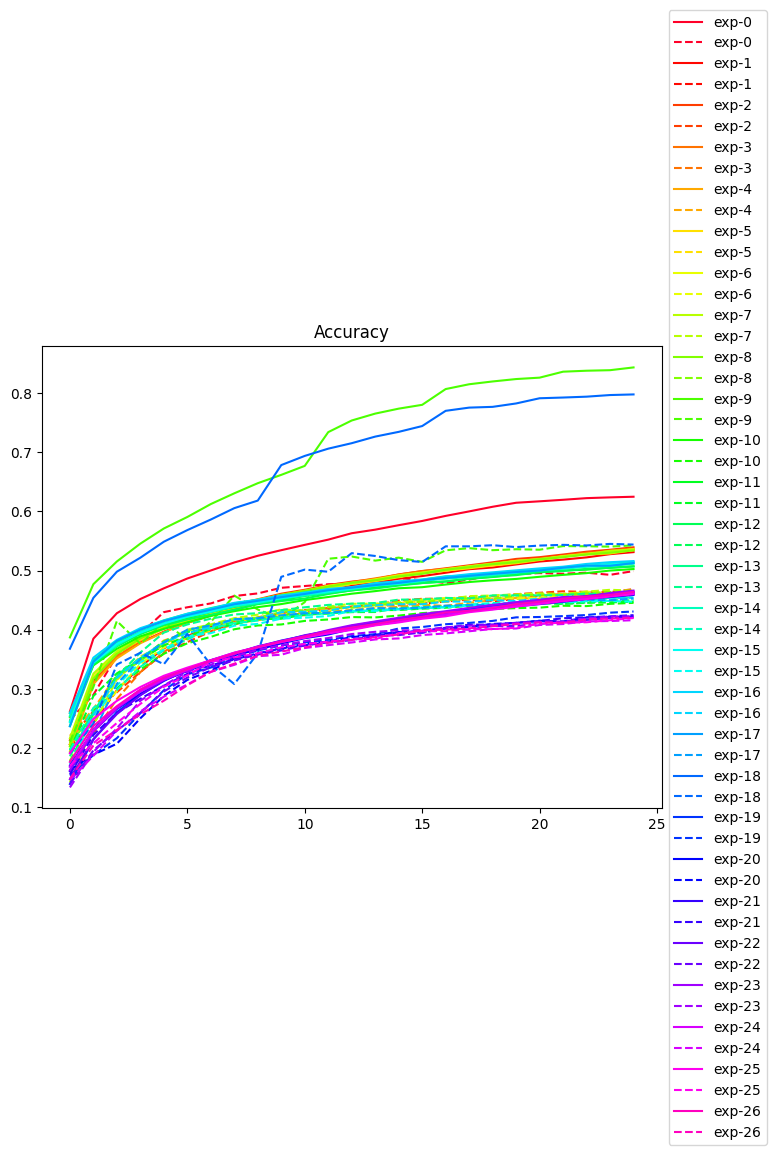

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()